We tried running several other models. Didn't work out since the best algorithm to deal with a huge number of features is the random forest

Tried to find correlation between the data by using covariance matrix. Didn't worked out.

Tried to treat the data as time series to see what we could derive from it

Tried PCA + RF

Tried to spot outliers

## Structure of the Dataset

### Main data

In [8]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()

In [9]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import mean_squared_error

In [10]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error


In [11]:
problem = imp.load_source('', 'problem.py') #problem is a module with different methods
X_df, y_array = problem.get_train_data() #get_train_data() is one of those methods

X_train = X_df.copy()
y_train = y_array.copy()

In [12]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [13]:
X_train.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [14]:
X_train.shape

(8902, 5)

In [15]:
pd.DataFrame(data=X_train.isna().sum(), columns=["Number of NAs"]).transpose()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
Number of NAs,0,0,0,0,0


There are no missing values

### Additional Data (IATA)

In [16]:
#Join iata data
iata = pd.read_csv('data/IATA_US_CODES.csv')
iata['IATA Code']=iata['IATA Code'].astype(str)
iata['IATA Code']=iata['IATA Code'].str.rstrip()
iata=iata.set_index('IATA Code')
iata_dep=iata.add_suffix('_Dep')
iata_arr=iata.add_suffix('_Arr')

In [17]:
X_train=X_train.join(iata_dep, on='Departure', how='left')
X_train=X_train.join(iata_arr, on='Arrival', how='left')
X_train['Departure']

0       ORD
1       LAS
2       DEN
3       ATL
4       DEN
       ... 
8897    DTW
8898    DFW
8899    SFO
8900    ORD
8901    DTW
Name: Departure, Length: 8902, dtype: object

In [18]:
X_train

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Rank_2018_Dep,Airports (large hubs)_Dep,Major city served_Dep,State_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,Airports (large hubs)_Arr,Major city served_Arr,State_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr
0,2012-06-19,ORD,DFW,12.875000,9.812647,3,O'Hare International Airport,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",4,Dallas/Fort Worth International Airport,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832"
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,McCarran International Airport,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver International Airport,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043"
2,2012-10-05,DEN,LAX,10.863636,9.035883,5,Denver International Airport,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",2,Los Angeles International Airport,Los Angeles,CA,"42,626,783","41,232,432","39,636,042","36,351,226"
3,2011-10-09,ATL,ORD,11.480000,7.990202,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732",3,O'Hare International Airport,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
4,2012-02-21,DEN,SFO,11.450000,9.517159,5,Denver International Airport,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",7,San Francisco International Airport,San Francisco,CA,"27,794,154","26,900,048","25,707,101","24,190,549"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967,19,Detroit Metropolitan Airport,Detroit,MI,"17,437,716","17,036,092","16,826,287","16,255,520",1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732"
8898,2012-09-25,DFW,ORD,12.772727,10.641034,4,Dallas/Fort Worth International Airport,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832",3,O'Hare International Airport,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
8899,2012-01-19,SFO,LAS,11.047619,7.908705,7,San Francisco International Airport,San Francisco,CA,"27,794,154","26,900,048","25,707,101","24,190,549",9,McCarran International Airport,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231"
8900,2013-02-03,ORD,PHL,6.076923,4.030334,3,O'Hare International Airport,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",20,Philadelphia International Airport,Philadelphia,PA,"15,285,948","14,271,243","14,564,419","15,101,318"


In [19]:
X_train=X_train.drop(['Airports (large hubs)_Dep', 'Airports (large hubs)_Arr'], axis=1)
X_train

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Rank_2018_Dep,Major city served_Dep,State_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,Major city served_Arr,State_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr
0,2012-06-19,ORD,DFW,12.875000,9.812647,3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",4,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832"
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043"
2,2012-10-05,DEN,LAX,10.863636,9.035883,5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",2,Los Angeles,CA,"42,626,783","41,232,432","39,636,042","36,351,226"
3,2011-10-09,ATL,ORD,11.480000,7.990202,1,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732",3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
4,2012-02-21,DEN,SFO,11.450000,9.517159,5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",7,San Francisco,CA,"27,794,154","26,900,048","25,707,101","24,190,549"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967,19,Detroit,MI,"17,437,716","17,036,092","16,826,287","16,255,520",1,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732"
8898,2012-09-25,DFW,ORD,12.772727,10.641034,4,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832",3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
8899,2012-01-19,SFO,LAS,11.047619,7.908705,7,San Francisco,CA,"27,794,154","26,900,048","25,707,101","24,190,549",9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231"
8900,2013-02-03,ORD,PHL,6.076923,4.030334,3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",20,Philadelphia,PA,"15,285,948","14,271,243","14,564,419","15,101,318"


In [20]:
X_train['2018_Arr'].astype

<bound method NDFrame.astype of 0       32,800,721 
1       31,363,573 
2       42,626,783 
3       39,874,879 
4       27,794,154 
           ...     
8897    51,866,464 
8898    39,874,879 
8899    23,655,285 
8900    15,285,948 
8901    51,866,464 
Name: 2018_Arr, Length: 8902, dtype: object>

In [21]:
iata['2018']=iata['2018'].str.replace(',','')
iata['2017']=iata['2017'].str.replace(',','')
iata['2016']=iata['2016'].str.replace(',','')
iata['2015']=iata['2015'].str.replace(',','')
iata['2018']=iata['2018'].str.replace('\xa0','')
iata['2017']=iata['2017'].str.replace('\xa0','')
iata['2016']=iata['2016'].str.replace('\xa0','')
iata['2015']=iata['2015'].str.replace('\xa0','')


In [22]:
iata['2018'] = iata['2018'].astype(int)

In [23]:
iata

,Rank_2018,Airports (large hubs),Major city served,State,2018,2017,2016,2015
IATA Code,,,,,,,,
ATL,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,51866464,50251964,50501858,49340732
LAX,2,Los Angeles International Airport,Los Angeles,CA,42626783,41232432,39636042,36351226
ORD,3,O'Hare International Airport,Chicago,IL,39874879,38593028,37589899,36305668
DFW,4,Dallas/Fort Worth International Airport,Dallas/Fort Worth,TX,32800721,31816933,31283579,31589832
DEN,5,Denver International Airport,Denver,CO,31363573,29809097,28267394,26280043
JFK,6,John F. Kennedy International Airport,New York,NY,30541459,29533154,29239151,27782369
SFO,7,San Francisco International Airport,San Francisco,CA,27794154,26900048,25707101,24190549
SEA,8,Seattle–Tacoma International Airport,Seattle/Tacoma,WA,24894338,22639124,21887110,21231781
LAS,9,McCarran International Airport,Las Vegas,NV,23655285,23364393,22833267,21824231


In [24]:
#Add distance between cities
us_cities = pd.read_csv('data/uscities.csv')
us_cities

,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,South Creek,South Creek,WA,Washington,53053,Pierce,53053,Pierce,46.9994,-122.3921,2500.0,125.0,polygon,False,True,America/Los_Angeles,3,98580 98387 98338,1840116412
1,Roslyn,Roslyn,WA,Washington,53037,Kittitas,53037,Kittitas,47.2507,-121.0989,947.0,84.0,polygon,False,True,America/Los_Angeles,3,98941 98068 98925,1840097718
2,Sprague,Sprague,WA,Washington,53043,Lincoln,53043,Lincoln,47.3048,-117.9713,441.0,163.0,polygon,False,True,America/Los_Angeles,3,99032,1840096300
3,Gig Harbor,Gig Harbor,WA,Washington,53053,Pierce,53053,Pierce,47.3352,-122.5968,9507.0,622.0,polygon,False,True,America/Los_Angeles,3,98332 98335,1840097082
4,Lake Cassidy,Lake Cassidy,WA,Washington,53061,Snohomish,53061,Snohomish,48.0639,-122.0920,3591.0,131.0,polygon,False,True,America/Los_Angeles,3,98223 98258 98270,1840116371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28884,Montrose,Montrose,SD,South Dakota,46087,McCook,46087,McCook,43.7002,-97.1843,442.0,414.0,polygon,False,True,America/Chicago,3,57048,1840081860
28885,Spearfish,Spearfish,SD,South Dakota,46081,Lawrence,46081,Lawrence,44.4912,-103.8167,12675.0,272.0,polygon,False,True,America/Denver,3,57783 57799,1840082231
28886,Emery,Emery,SD,South Dakota,46061,Hanson,46061,Hanson,43.6020,-97.6195,455.0,384.0,polygon,False,True,America/Chicago,3,57332,1840081745
28887,Watertown,Watertown,SD,South Dakota,46029,Codington,46029,Codington,44.9094,-97.1532,21837.0,475.0,polygon,False,True,America/Chicago,3,57201,1840081993


In [25]:
us_cities_dep = us_cities.add_suffix('_dep')
us_cities_dep = us_cities_dep.set_index('city_dep')

us_cities_arr = us_cities.add_suffix('_arr')
us_cities_arr = us_cities_arr.set_index('city_arr')

X_train = X_train.join(us_cities_dep, how='left', on='Major city served_Dep')
X_train = X_train.join(us_cities_arr, how='left', on='Major city served_Arr')

In [26]:
X_train

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Rank_2018_Dep,Major city served_Dep,State_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,Major city served_Arr,State_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr,city_ascii_dep,state_id_dep,state_name_dep,county_fips_dep,county_name_dep,county_fips_all_dep,county_name_all_dep,lat_dep,lng_dep,population_dep,density_dep,source_dep,military_dep,incorporated_dep,timezone_dep,ranking_dep,zips_dep,id_dep,city_ascii_arr,state_id_arr,state_name_arr,county_fips_arr,county_name_arr,county_fips_all_arr,county_name_all_arr,lat_arr,lng_arr,population_arr,density_arr,source_arr,military_arr,incorporated_arr,timezone_arr,ranking_arr,zips_arr,id_arr
0,2012-06-19,ORD,DFW,12.875000,9.812647,3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",4,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832",Chicago,IL,Illinois,17031.0,Cook,17031,Cook,41.8373,-87.6862,8675982.0,4612.0,polygon,False,True,America/Chicago,1.0,60018 60649 60641 60640 60643 60642 60645 6064...,1.840022e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",Las Vegas,NM,New Mexico,35047.0,San Miguel,35047,San Miguel,35.6011,-105.2206,14982.0,651.0,polygon,False,True,America/Denver,3.0,87701,1.840055e+09,Denver,NC,North Carolina,37109.0,Lincoln,37109,Lincoln,35.5344,-81.0340,2727.0,177.0,polygon,False,False,America/New_York,3.0,28037,1.840116e+09
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",Las Vegas,NM,New Mexico,35047.0,San Miguel,35047,San Miguel,35.6011,-105.2206,14982.0,651.0,polygon,False,True,America/Denver,3.0,87701,1.840055e+09,Denver,PA,Pennsylvania,42071.0,Lancaster,42071,Lancaster,40.2325,-76.1393,3879.0,1170.0,polygon,False,True,America/New_York,3.0,17517,1.840073e+09
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",Las Vegas,NM,New Mexico,35047.0,San Miguel,35047,San Miguel,35.6011,-105.2206,14982.0,651.0,polygon,False,True,America/Denver,3.0,87701,1.840055e+09,Denver,CO,Colorado,8031.0,Denver,08031,Denver,39.7621,-104.8759,2787266.0,1774.0,polygon,False,True,America/Denver,1.0,80264 80230 80231 80236 80237 80235 80238 8023...,1.840009e+09
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",Las Vegas,NM,New Mexico,35047.0,San Miguel,35047,San Miguel,35.6011,-105.2206,14982.0,651.0,polygon,False,True,America/Denver,3.0,87701,1.840055e+09,Denver,IN,Indiana,18103.0,Miami,18103,Miami,40.8645,-86.0771,471.0,780.0,polygon,False,True,America/Indiana/Indianapolis,3.0,46926,1.840022e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,2011-11-26,DTW,ATL,9.526316,6.167733,19,Detroit,MI,"17,437,716","17,036,092","16,826,287","16,255,520",1,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732",Detroit,OR,Oregon,41047.0,Marion,41047,Marion,44.7338,-122.1512,221.0,145.0,polygon,False,True,America/Los_Angeles,3.0,97342,1.840072e+09,Atlanta,GA,Georgia,13121.0,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1.0,30334 30331 30332 30309 30308 30305 30307 3030...,1.840016e+09
8901,2011-11-26,DTW,ATL,9.526316,6.167733,19,Detroit,MI,"17,437,716","17,036,092","16,826,287","16,255,520",1,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732",Detroit,OR,Oregon,41047.0,Marion,41047,Marion,44.7

In [27]:
X_train.isna()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Rank_2018_Dep,Major city served_Dep,State_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,Major city served_Arr,State_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr,city_ascii_dep,state_id_dep,state_name_dep,county_fips_dep,county_name_dep,county_fips_all_dep,county_name_all_dep,lat_dep,lng_dep,population_dep,density_dep,source_dep,military_dep,incorporated_dep,timezone_dep,ranking_dep,zips_dep,id_dep,city_ascii_arr,state_id_arr,state_name_arr,county_fips_arr,county_name_arr,county_fips_all_arr,county_name_all_arr,lat_arr,lng_arr,population_arr,density_arr,source_arr,military_arr,incorporated_arr,timezone_arr,ranking_arr,zips_arr,id_arr
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [28]:
data_weather = pd.read_csv('submissions/starting_kit/external_data.csv')
data_weather

,Unnamed: 0,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,State,2018,2017,2016,2015,city,lat,lng,population,density,ranking,Fuel_price,Holiday
0,0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3088,0
1,1,2011-09-01,ORD,34,28,22,23,22,19,84,70,56,1015,1013,1011,16,15,11,26,9,37.0,0.00,1,NaN,197,3,IL,39874879,38593028,37589899,36305668,Chicago,41.8373,-87.6862,8675982.0,4612.0,1,3088,0
2,2,2011-09-01,LAX,21,18,15,14,14,13,90,76,61,1012,1011,1009,16,11,4,23,13,NaN,0.00,5,Fog,265,2,CA,42626783,41232432,39636042,36351226,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,1,3088,0
3,3,2011-09-01,DFW,38,33,27,17,14,11,51,35,19,1015,1013,1010,16,16,16,34,14,45.0,0.00,1,NaN,157,4,TX,32800721,31816933,31283579,31589832,Dallas,32.7936,-96.7662,5733259.0,1524.0,1,3088,0
4,4,2011-09-01,DEN,36,28,20,5,3,-2,34,22,9,1016,1007,1004,16,16,16,29,15,39.0,0.00,5,NaN,205,5,CO,31363573,29809097,28267394,26280043,Denver,39.7621,-104.8759,2787266.0,1774.0,1,3088,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11035,11035,2013-03-05,MSP,-1,-3,-6,-4,-5,-8,100,85,69,1027,1019,1015,16,6,1,27,15,40.0,10.41,8,Fog-Snow,44,17,MN,18363493,18409704,18123844,17634252,Minneapolis,44.9635,-93.2678,2926757.0,3019.0,1,3021,0
11036,11036,2013-03-05,DTW,2,-2,-6,-5,-6,-8,81,69,56,1021,1016,1010,16,16,16,32,16,42.0,0.00,5,NaN,58,19,MI,17437716,17036092,16826287,16255520,Detroit,42.3834,-83.1024,3522206.0,1873.0,1,3021,0
11037,11037,2013-03-05,PHL,9,4,-1,-2,-6,-7,70,53,36,1018,1016,1014,16,16,16,26,11,32.0,0.00,3,NaN,39,20,PA,15285948,14271243,14564419,15101318,Philadelphia,40.0077,-75.1339,5637884.0,4547.0,1,3021,0
11038,11038,2013-03-05,BOS,6,3,0,1,-3,-7,82,68,53,1018,1014,1007,16,16,14,39,17,52.0,T,7,Rain,359,16,MA,20010262,18759742,17749202,16290362,Boston,42.3188,-71.0846,4637537.0,5472.0,1,3021,0


## Data cleaning and preprocessing

In [29]:
X_train = X_df.copy()
y_train = y_array.copy()

In [30]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [31]:
import os
from math import *

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def transform(X_df):
    X_encoded = X_df.copy()
    
    #Read data
    __file__ = 'submissions/starting_kit/'
    path = os.path.dirname(__file__)
    data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
    
    #Weather
    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
    
    X_encoded = pd.merge(
        X_encoded, X_weather, how='left',
        left_on=['DateOfDeparture', 'Arrival'],
        right_on=['DateOfDeparture', 'Arrival'],
        sort=False)
    
    #External data but not weather
    X_ext=data_weather[['Date', 'AirPort','Rank_2018','State','city','lat','lng','population','density','ranking','Fuel_price','Holiday']]
    
    Dep_data=X_ext.add_suffix('_Dep')
    Arr_data=X_ext.add_suffix('_Arr')
    
    X_encoded=pd.merge(X_encoded, Dep_data, how='left', left_on=['DateOfDeparture', 'Departure'],
        right_on=['Date_Dep', 'AirPort_Dep'],
        sort=False )
    
    X_encoded=pd.merge(X_encoded, Arr_data, how='left', left_on=['DateOfDeparture', 'Arrival'],
        right_on=['Date_Arr', 'AirPort_Arr'],
        sort=False )
    
    
    #Dummy Depart/Arr
    X_encoded = X_encoded.join(pd.get_dummies(
        X_encoded['Departure'], prefix='d'))
    X_encoded = X_encoded.join(
        pd.get_dummies(X_encoded['Arrival'], prefix='a'))
    

    
    #Distance calculation
    X_encoded['Distance']=X_encoded.apply(lambda x:
    haversine(x['lng_Dep'],x['lat_Dep'],x['lng_Arr'],x['lat_Arr']),axis=1)
    
    
    #Dummy Date
    X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 5 == 1).astype(float)
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

    #We one hot encode all those
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
    X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
    X_encoded = X_encoded.drop('Departure', axis=1)
    X_encoded = X_encoded.drop('Arrival', axis=1)
    
    X_encoded=X_encoded.drop(['Date_Dep','Date_Arr',
                              'city_Dep','city_Arr','AirPort_Dep',
                              'State_Dep', 'AirPort_Arr', 'State_Arr',
                              'Fuel_price_Arr','Holiday_Arr','year','month','week','day',
                              'weekday','lat_Dep','lng_Dep','lat_Arr','lng_Arr'], axis=1)
    
    return X_encoded



In [40]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)
X_train

,WeeksToDeparture,std_wtd,Max TemperatureC,Rank_2018_Dep,population_Dep,density_Dep,ranking_Dep,Fuel_price_Dep,Holiday_Dep,Rank_2018_Arr,population_Arr,density_Arr,ranking_Arr,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,Distance,Weekend,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,9.812647,34,3,8675982.0,4612.0,1,2719,0,4,5733259.0,1524.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1285.250403,0.0,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,33,9,2073045.0,1747.0,1,3247,0,5,2787266.0,1774.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,990.537032,0.0,15593,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,9.035883,22,5,2787266.0,1774.0,1,3158,0,2,12815475.0,3295.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1354.641049,0.0,15618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,7.990202,27,1,5228750.0,1384.0,1,2881,0,3,8675982.0,4612.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,942.326564,1.0,15256,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,9.517159,16,5,2787266.0,1774.0,1,3237,0,7,3603761.0,7286.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1536.901253,0.0,15391,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,9.263158,7.316967,20,19,3522206.0,1873.0,1,2844,0,1,5228750.0,1384.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,965.480802,1.0,15249,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,12.772727,10.641034,25,4,5733259.0,1524.0,1,3135,0,3,8675982.0,4612.0,1,0,0,0,0,1,0,0,0,0,0,

## Train the model

### Gradient Boosting

In [75]:
GB = GradientBoostingRegressor(n_estimators=12000,
            learning_rate=0.05, max_depth=3, max_features='sqrt',
            min_samples_leaf=15, min_samples_split=10, loss='huber')
GB.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=12000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

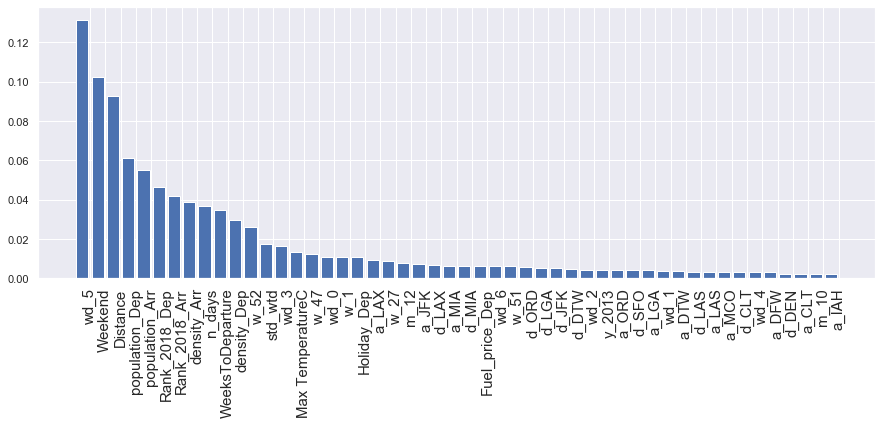

In [76]:
X_columns=X_train.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(GB.feature_importances_)[::-1][:50]

importances = GB.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);
#plots showing how important each column is in the prediction

In [77]:
y_pred_train = GB.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.22872996341425936


In [78]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)

In [79]:
y_pred = GB.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.37265439052022953


### Random Forest

In [84]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [85]:
RF = RandomForestRegressor(
            n_estimators=600, max_depth=110, max_features='sqrt',
             min_samples_split=10, min_samples_leaf=1, bootstrap=True)
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=110,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [86]:
y_pred_train = RF.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.30235033105518516


In [87]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = RF.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.4794543345631686


### Lasso

In [ ]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [92]:
LR = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
LR.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=1, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [93]:
y_pred_train = LR.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.5913207660217837


In [94]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = LR.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.6299112404459802


### ElasticNet

In [ ]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [97]:
EN = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
EN.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=3,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [98]:
y_pred_train = EN.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.5909815480494767


In [99]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = EN.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.6297524587201996


### Ada Boost

In [32]:
from sklearn.ensemble import AdaBoostRegressor
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [33]:
AR=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
        n_estimators=100, random_state=0)
AR.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0)

In [34]:
y_pred_train = AR.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.7000046022054104


In [35]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = AR.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.7268548027080755
